In [22]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from collections import Counter
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import random
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [23]:
nltk.download('punkt_tab')

text= """The Sun rises in the east and sets in the west. the king is the father and mother. """
stemmer=PorterStemmer()
tokens=word_tokenize(text.lower())
tokens=[stemmer.stem(token) for token in tokens if token.isalpha()]

word_counts=Counter(tokens)
vocab=list(word_counts.keys())
word_to_ix={word: i for i, word in enumerate(vocab)}
ix_to_word={i: word for word, i in word_to_ix.items()}
vocab_size=len(vocab)

print("Vocabulary:", vocab)

Vocabulary: ['the', 'sun', 'rise', 'in', 'east', 'and', 'set', 'west', 'king', 'is', 'father', 'mother']


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\rajas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [24]:
CONTEXT_SIZE = 2 # context window

def make_cbow_dataset(tokens):
    dataset = []
    for i in range(CONTEXT_SIZE, len (tokens) - CONTEXT_SIZE):
        context = [tokens [i-j-1] for j in range(CONTEXT_SIZE)] + \
                  [tokens [i + j + 1] for j in range(CONTEXT_SIZE)]

        target = tokens[i]
        dataset.append((context, target))
    return dataset
cbow_data = make_cbow_dataset(tokens)

In [25]:
print(cbow_data)

[(['sun', 'the', 'in', 'the'], 'rise'), (['rise', 'sun', 'the', 'east'], 'in'), (['in', 'rise', 'east', 'and'], 'the'), (['the', 'in', 'and', 'set'], 'east'), (['east', 'the', 'set', 'in'], 'and'), (['and', 'east', 'in', 'the'], 'set'), (['set', 'and', 'the', 'west'], 'in'), (['in', 'set', 'west', 'the'], 'the'), (['the', 'in', 'the', 'king'], 'west'), (['west', 'the', 'king', 'is'], 'the'), (['the', 'west', 'is', 'the'], 'king'), (['king', 'the', 'the', 'father'], 'is'), (['is', 'king', 'father', 'and'], 'the'), (['the', 'is', 'and', 'mother'], 'father')]


In [26]:
def make_skipgram_dataset(tokens, n_gram=2):
    dataset = []
    for i in range(n_gram, len(tokens) - n_gram):
        target = tokens [1]
        context = [tokens[i-j] for j in range(1, n_gram + 1)] + \
                  [tokens[i + j] for j in range (1, n_gram + 1)]
        for ctx in context:
            dataset. append ((target, ctx))
    return dataset

In [41]:
class Word2VecDataset(Dataset) :
    def __init__(self, data, word_to_ix):
        self.data = data
        self.word_to_ix = word_to_ix
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        context, target = self.data[idx]
        context_idxs = torch.tensor ([self.word_to_ix[w] for w in context], dtype=torch.long)
        target_idx = torch.tensor(self.word_to_ix[target], dtype=torch.long)
        return context_idxs, target_idx

In [39]:
import torch
import torch.nn as nn 
import torch.nn.functional as F

class CBOWModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim) :
        super (CBOWModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size)
    def forward(self, context):
    # context: [batch_size,context_size]
        embedded = self.embeddings(context)
        embedded = embedded.mean(dim=1)
        out = self.linear(embedded)
        return out

In [37]:
def train_model(model, dataset, epochs=20, lr=0.01):
    model.train()
    loss_fn=nn.CrossEntropyLoss()
    optimizer=torch.optim.Adam(model.parameters(), lr=lr)
    all_losses= []
    for epoch in range(epochs):
        total_loss=0
        for context, target in dataset:
            context= torch.tensor(context).unsqueeze (0)
            target =torch.tensor([target])
            output= model(context)
            loss= loss_fn(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        all_losses.append(total_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")
        if epoch % 10 == 0:
    # print(f"Epoch {epoch}, Loss: {total_loss:.4f}")
            visualize_embeddings(model.embeddings.weight.data, ix_to_word)
    return model, all_losses

C:\Users\rajas\AppData\Local\Temp\ipykernel_23168\4127575001.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  context= torch.tensor(context).unsqueeze (0)


Epoch 1/50, Loss: 37.5361


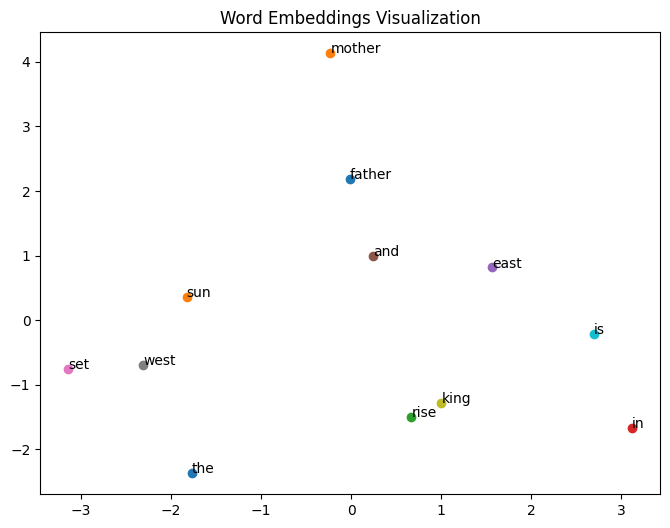

C:\Users\rajas\AppData\Local\Temp\ipykernel_23168\4127575001.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  context= torch.tensor(context).unsqueeze (0)


Epoch 2/50, Loss: 32.1280
Epoch 3/50, Loss: 29.1373
Epoch 4/50, Loss: 26.8196
Epoch 5/50, Loss: 24.8402
Epoch 6/50, Loss: 23.0180
Epoch 7/50, Loss: 21.2640
Epoch 8/50, Loss: 19.5471
Epoch 9/50, Loss: 17.8664
Epoch 10/50, Loss: 16.2356
Epoch 11/50, Loss: 14.6757


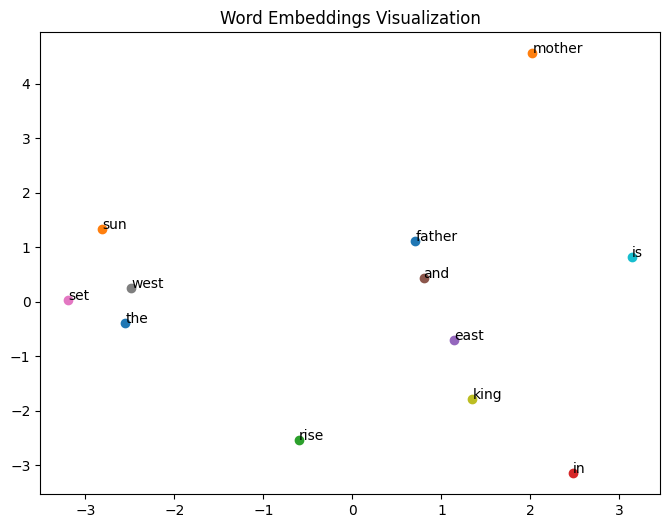

C:\Users\rajas\AppData\Local\Temp\ipykernel_23168\4127575001.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  context= torch.tensor(context).unsqueeze (0)


Epoch 12/50, Loss: 13.2091
Epoch 13/50, Loss: 11.8542
Epoch 14/50, Loss: 10.6214
Epoch 15/50, Loss: 9.5128
Epoch 16/50, Loss: 8.5236
Epoch 17/50, Loss: 7.6456
Epoch 18/50, Loss: 6.8688
Epoch 19/50, Loss: 6.1826
Epoch 20/50, Loss: 5.5767
Epoch 21/50, Loss: 5.0414


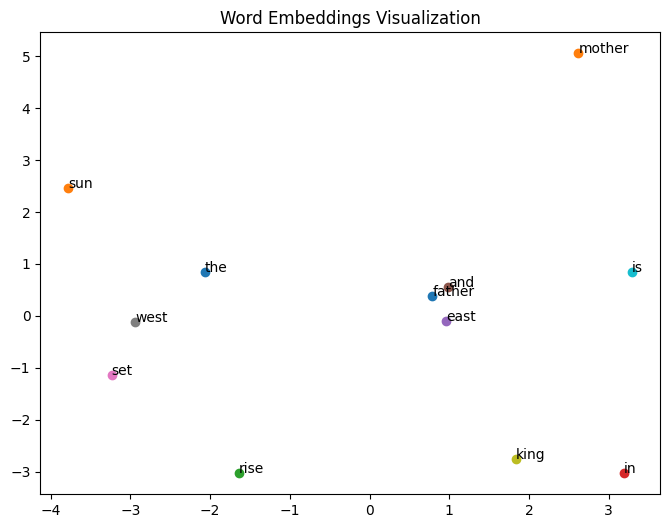

C:\Users\rajas\AppData\Local\Temp\ipykernel_23168\4127575001.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  context= torch.tensor(context).unsqueeze (0)


Epoch 22/50, Loss: 4.5679
Epoch 23/50, Loss: 4.1485
Epoch 24/50, Loss: 3.7762
Epoch 25/50, Loss: 3.4451
Epoch 26/50, Loss: 3.1500
Epoch 27/50, Loss: 2.8865
Epoch 28/50, Loss: 2.6507
Epoch 29/50, Loss: 2.4393
Epoch 30/50, Loss: 2.2494
Epoch 31/50, Loss: 2.0785


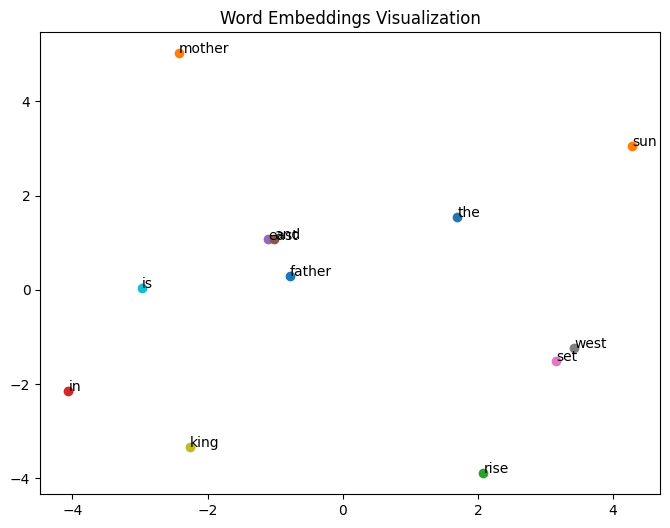

C:\Users\rajas\AppData\Local\Temp\ipykernel_23168\4127575001.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  context= torch.tensor(context).unsqueeze (0)


Epoch 32/50, Loss: 1.9245
Epoch 33/50, Loss: 1.7854
Epoch 34/50, Loss: 1.6596
Epoch 35/50, Loss: 1.5456
Epoch 36/50, Loss: 1.4421
Epoch 37/50, Loss: 1.3479
Epoch 38/50, Loss: 1.2622
Epoch 39/50, Loss: 1.1839
Epoch 40/50, Loss: 1.1123
Epoch 41/50, Loss: 1.0467


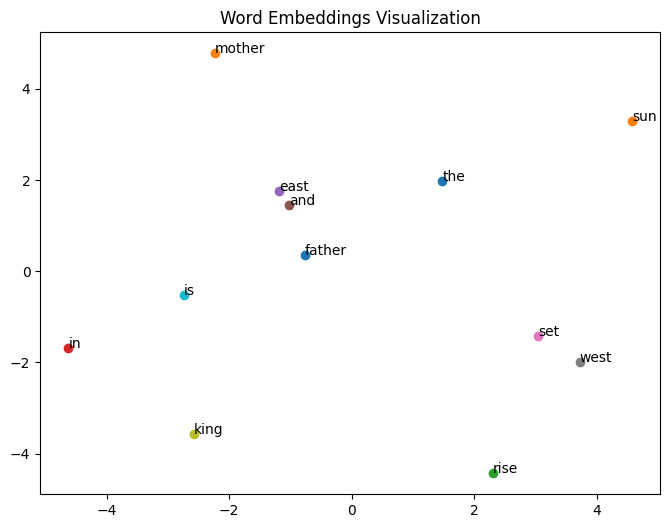

Epoch 42/50, Loss: 0.9864
Epoch 43/50, Loss: 0.9311
Epoch 44/50, Loss: 0.8801
Epoch 45/50, Loss: 0.8330
Epoch 46/50, Loss: 0.7895
Epoch 47/50, Loss: 0.7492
Epoch 48/50, Loss: 0.7119
Epoch 49/50, Loss: 0.6772
Epoch 50/50, Loss: 0.6449


C:\Users\rajas\AppData\Local\Temp\ipykernel_23168\4127575001.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  context= torch.tensor(context).unsqueeze (0)


In [45]:
embedding_dim = 15
cbow_dataset =Word2VecDataset([(ctx, tgt) for ctx, tgt in cbow_data], word_to_ix)
cbow_model = CBOWModel(vocab_size, embedding_dim)
trained_cbow, cbow_losess = train_model(cbow_model, cbow_dataset, epochs=50)